## Mining Drug Recall Reasons from OpenFDA.
#### Topic Mining: Visualizing topics in text with LDA

####  Aashish Tiwari ( **AI LAB TEAM** - Persistent Systems Ltd.)


## Table of contents


1. [Step 1: Environment Setup](#Step-1:-Environment-Setup)

2. [Step 2: Data acquisition from OpenFDA](#Step-2:-Data-acquisition-from-OpenFDA)

3. [Step 3: Data analysis](#Step-3:-Data-analysis)
    - [Data discovery](#Data-discovery)
    - [Text processing : tokenization](#Text-processing-:-tokenization)
    - [Text processing : tf-idf](#Text-processing-:-tf-idf)

4. [Step 4: Clustering](#Step-4:-Clustering)
    - [KMeans](#KMeans)
    - [Latent Dirichlet Allocation](#Latent-Dirichlet-Allocation)
    - [Visualization of the topics using pyLDAvis](#Visualization-of-the-topics-using-pyLDAvis)

5. [Step 5: Conclusion](#Step-5:-Conclusion)

6. [Step 6: References](#Step-6:-References)

### Introduction

## Step 1: Environment Setup

[[ go back to the top ]](#Table-of-contents)

We suggest downloading the Anaconda distribution for python 3.6 from this <a href="https://www.continuum.io/downloads">link</a>. This distribution wraps python with the necessary packages used in data science like Numpy, Pandas, Scipy or Scikit-learn.

For the purpose of this tutorial we'll also have to download external packages:

- **tqdm** (a progress bar python utility) from this command: pip install tqdm
- **nltk** (for natural language processing) from this command: conda install -c anaconda nltk=3.2.2
- **bokeh** (for interactive data viz) from this command: conda install bokeh
- **lda** (the python implementation of Latent Dirichlet Allocation) from this command: pip install lda
- **pyldavis** (python package to visualize lda topics): pip install pyldavis

To connect to the Newsapi service you'll have to create an account at https://newsapi.org/register to get a key. It's totally free. Then you'll have to put your key in the code and run the script on your own if you want to. 

## Step 2: Data acquisition from OpenFDA

[[ go back to the top ]](#Table-of-contents)

https://open.fda.gov/downloads/
The JSON file resulting from this response download is pretty straightforward:

```
{
      "classification": "Class II",
      "center_classification_date": "20170315",
      "report_date": "20170322",
      "postal_code": "92117-7310",
      "recall_initiation_date": "20170210",
      "recall_number": "D-0546-2017",
      "city": "San Diego",
      "event_id": "76472",
      "distribution_pattern": "Nationwide within the United States",
      "openfda": {},
      "recalling_firm": "Synergy Rx",
      "voluntary_mandated": "Voluntary: Firm Initiated",
      "state": "CA",
      "reason_for_recall": "Lack of Assurance of Sterility: There are also CGMP Deviations. ",
      "initial_firm_notification": "Telephone",
      "status": "Ongoing",
      "product_type": "Drugs",
      "country": "United States",
      "product_description": "VITAMIN K OXIDE 5%, HQ 4%, Rx only, Synergy RX, 4901 Morena Blvd # 504-A San Diego, CA 92117 (855) 792-6676",
      "code_info": " All Lots",
      "address_1": "4901 Morena Blvd Ste 504A",
      "address_2": "",
      "product_quantity": ""
    }
```

Let's get into the code to see how to manage this data acquisition:

In [1]:
# import packages
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
import json

In [2]:
def get_reason_for_recall():
    all_recalls = []
    with open('drug-enforcement-0001-of-0001.json') as data_file:    
        data = json.load(data_file)
    for res in data['results']:
        recalls = [uniq_reason for uniq_reason in res['reason_for_recall'].split(';')]
        all_recalls.extend(recalls)
    return set(all_recalls)

In [3]:
all_uniq_reasons = get_reason_for_recall()
print('number of unique reasons :', len(all_uniq_reasons))

number of unique reasons : 2602


Now that the data has been collected, we will start anlayzing it :

- We'll have a look at the dataset and inspect it
- We'll apply some preoprocessings on the texts: tokenization, tf-idf
- We'll cluster the articles using two different algorithms (Kmeans and LDA)
- We'll visualize the clusters using Bokeh and pyldavis

## Step 3: Data analysis

[[ go back to the top ]](#Table-of-contents)

### Data discovery
[[ go back to the top ]](#Table-of-contents)

In [4]:
%matplotlib inline
# pandas for data manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
# nltk for nlp
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# list of stopwords like articles, preposition
stop = set(stopwords.words('english'))
from string import punctuation
from collections import Counter
import re
import numpy as np

In [5]:
with open('drug-enforcement-0001-of-0001.json') as data_file:    
    drug_data = json.load(data_file)

In [6]:
data = pd.DataFrame.from_records(drug_data['results'])

The data is now ingested in a Pandas DataFrame.

Let's see how it looks like.

In [7]:
data.head()

,address_1,address_2,center_classification_date,city,classification,code_info,country,distribution_pattern,event_id,initial_firm_notification,...,product_type,reason_for_recall,recall_initiation_date,recall_number,recalling_firm,report_date,state,status,termination_date,voluntary_mandated
0,7050 Camp Hill Rd,,20120702,Fort Washington,Class III,"Lot #CMF023, Expiration 07/13.",United States,Nationwide,61872,Letter,...,Drugs,Defective Container; damaged blister units,20120517,D-1404-2012,"Mcneil Consumer Healthcare, Div Of Mcneil-ppc,...",20120711,PA,Terminated,20130411,Voluntary: Firm Initiated
1,600 N Field Dr Bldg J45,,20120620,Lake Forest,Class III,"Lot #: 04510KL*, Exp 01OCT2012; *lot number m...",United States,Nationwide,62053,Letter,...,Drugs,Superpotent (Single Ingredient) Drug: Above sp...,20120405,D-1390-2012,"Hospira, Inc.",20120627,IL,Terminated,20130808,Voluntary: Firm Initiated
2,12515 E 55th St Ste 100,,20120618,Tulsa,Class I,PTC Drug Number: 4033. PTC Batch Number: 65I...,United States,FL,61233,FAX,...,Drugs,Labeling: Label mix-up; Bottles labeled to con...,20101110,D-1385-2012,"Physicians Total Care, Inc",20120627,OK,Terminated,20120724,Voluntary: Firm Initiated
3,150 Signet Drive,,20120802,Toronto,Class II,"Lot #s: JN1060, JN1061, JN1062, Exp 06/12",Canada,Nationwide and Puerto Rico,62574,Letter,...,Drugs,Presence of Particulate Matter: Lots identifi...,20120430,D-1439-2012,Apotex Inc.,20120808,,Terminated,20130919,Voluntary: Firm Initiated
4,200 Somerset Corporate Blvd Fl 7th,,20120731,Bridgewater,Class II,C201293 Exp Date 08/2013,United States,Nationwide and Puerto Rico,62591,Letter,...,Drugs,Adulterated Presence of Foreign Tablets: Dr. R...,20120409,D-1434-2012,"Dr. Reddy's Laboratories, Inc.",20120808,NJ,Terminated,20130124,Voluntary: Firm Initiated


It's cool to have all these features. In this article, we will be mainly focusing on the description column.

Let's look at the data shape.

In [8]:
print('data shape:', data.shape)

data shape: (7002, 25)


In [9]:
print("Number of Recalling Firms : ", len(data.recalling_firm.unique()))

Number of Recalling Firms :  659


Let's check the distribution of the different categories across the dataset.

### Recalling Firms with more than 20 Drug recalls

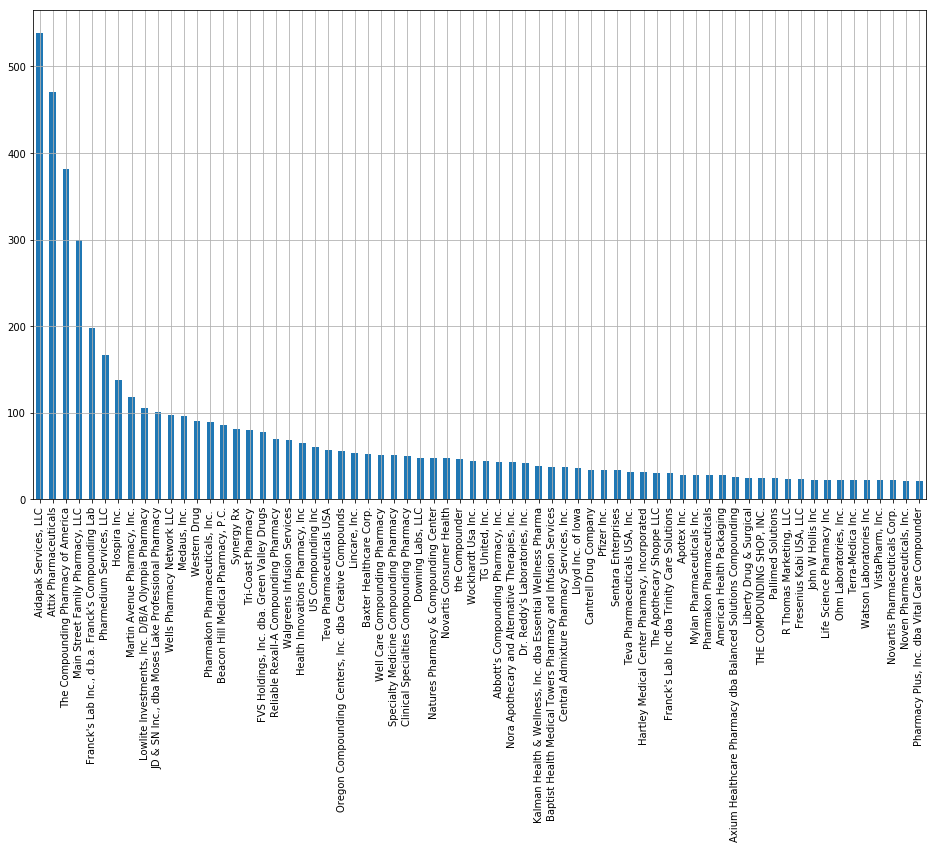

In [10]:
df1 = data.groupby('recalling_firm').filter(lambda x: len(x) > 20)
df1.recalling_firm.value_counts().plot(kind='bar', grid=True, figsize=(16, 9))

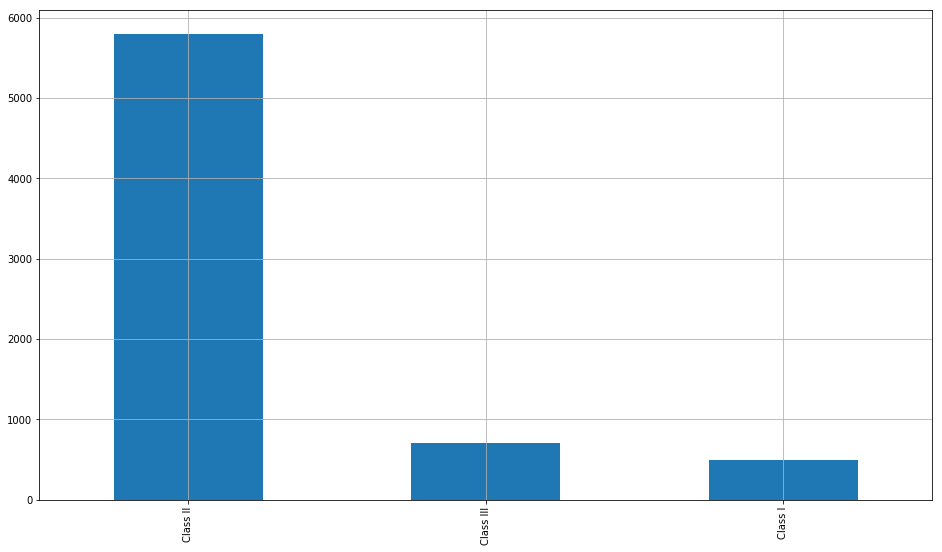

In [11]:
data.classification.value_counts().plot(kind='bar', grid=True, figsize=(16, 9))

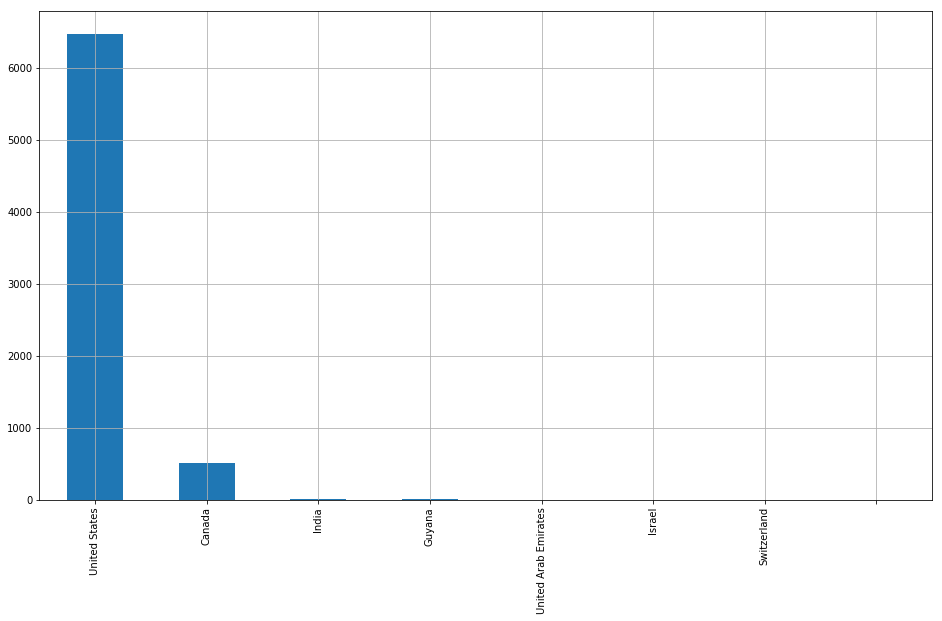

In [12]:
data.country.value_counts().plot(kind='bar', grid=True, figsize=(16, 9))

In [13]:
# remove duplicate description columns
data = data.drop_duplicates('reason_for_recall')

In [14]:
# remove rows with empty descriptions
data = data[~data['reason_for_recall'].isnull()]

In [15]:
data.shape

(2067, 25)

In [16]:
data['len'] = data['reason_for_recall'].map(len)

In [17]:
data.shape

(2067, 26)

### Text processing : tokenization
[[ go back to the top ]](#Table-of-contents)

Now we start by building a tokenizer. This will, for every description:

- break the descriptions into sentences and then break the sentences into tokens
- remove punctuation and stop words
- lowercase the tokens

In [18]:
def tokenizer(text):
    try:
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent

        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', 
                                            u'\u2014', u'\u2026', u'\u2013'], tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)

        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

        return filtered_tokens
    except Error as e:
        print(e)

A new column 'tokens' can be easily created using the map method applied to the 'description' column.

In [19]:
data['tokens'] = data['reason_for_recall'].map(tokenizer)

The tokenizer has been applied to each description through all rows. Each resulting value is then put into the 'tokens' column that is created after the assignment. Let's check what the tokenization looks like for the first 5 descriptions:

In [20]:
for descripition, tokens in zip(data['reason_for_recall'].head(5), data['tokens'].head(5)):
    print('reason_for_recall:', descripition)
    print('tokens:', tokens)
    print() 

reason_for_recall: Defective Container; damaged blister units 
tokens: ['defective', 'container', 'damaged', 'blister', 'units']

reason_for_recall: Superpotent (Single Ingredient) Drug: Above specification assay results for percentage of magnesium sulfate.
tokens: ['superpotent', 'single', 'ingredient', 'drug', 'specification', 'assay', 'results', 'percentage', 'magnesium', 'sulfate']

reason_for_recall: Labeling: Label mix-up; Bottles labeled to contain Morphine Sulfate IR may contain Morphine Sulfate ER and vice-versa.   
tokens: ['labeling', 'label', 'mix-up', 'bottles', 'labeled', 'contain', 'morphine', 'sulfate', 'ir', 'may', 'contain', 'morphine', 'sulfate', 'er', 'vice-versa']

reason_for_recall: Presence of Particulate Matter:  Lots identified in this recall notification may contain small particulates. 
tokens: ['presence', 'particulate', 'matter', 'lots', 'identified', 'recall', 'notification', 'may', 'contain', 'small', 'particulates']

reason_for_recall: Adulterated Presenc

Let's group the tokens by category, apply a word count and display the top 10 most frequent tokens. 

In [ ]:
def keywords(category):
    tokens = data[data['reason_for_recall'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [ ]:
for category in set(data['reason_for_recall']):
    print('reason_for_recall :', category)
    print('top 10 keywords:', keywords(category))
    print('---')

reason_for_recall : Subpotent Drug: Avobenzone 3%, one of the active sunscreen ingredients may be subpotent and sunscreen effectiveness may be less than labeled
top 10 keywords: [('subpotent', 2), ('sunscreen', 2), ('may', 2), ('labeled', 1), ('active', 1), ('drug', 1), ('less', 1), ('effectiveness', 1), ('avobenzone', 1), ('one', 1)]
---
reason_for_recall : Labeling: Label Mixup: CapsuleTOPRIL, Tablet, 25 mg may have potentially been mislabeled as the following drug:  DULoxetine HCl DR, Capsule, 20 mg, NDC 00002323560, Pedigree AD54587_4, EXP: 5/21/2014.  
top 10 keywords: [('mg', 2), ('mislabeled', 1), ('drug', 1), ('pedigree', 1), ('ad54587_4', 1), ('tablet', 1), ('exp', 1), ('mixup', 1), ('hcl', 1), ('dr', 1)]
---
reason_for_recall : Labeling: Label Mixup: LEVOTHYROXINE SODIUM, Tablet, 112 mcg may have potentially been mislabeled as the following drug:  MULTIVITAMIN/MULTIMINERAL, Tablet, 0 mg, NDC 00536406001, Pedigree: AD22865_13, EXP: 5/2/2014.  
top 10 keywords: [('tablet', 2), 

Looking at these lists, we can formulate some hypotheses:

- the sport category deals with the champions' league, the footbal season and NFL
- some tech articles refer to Google
- the business news seem to be highly correlated with US politics and Donald Trump (this mainly originates from us press)

Extracting the top 10 most frequent words per each category is straightforward and can point to important keywords. 

However, although we did preprocess the descriptions and remove the stop words before, we still end up with words that are very generic (e.g: today, world, year, first) and don't carry a specific meaning that may describe a topic.

As a first approach to prevent this, we'll use tf-idf

### Text processing : tf-idf
[[ go back to the top ]](#Table-of-contents)

tf-idf stands for term frequencey-inverse document frequency. It's a numerical statistic intended to reflect how important a word is to a document or a corpus (i.e a collection of documents). 

To relate to this post, words correpond to tokens and documents correpond to descriptions. A corpus is therefore a collection of descriptions.

The tf-idf a of a term t in a document d is proportional to the number of times the word t appears in the document d but is also offset by the frequency of the term t in the collection of the documents of the corpus. This helps adjusting the fact that some words appear more frequently in general and don't especially carry a meaning.

tf-idf acts therefore as a weighting scheme to extract relevant words in a document.

$$tfidf(t,d) = tf(t,d) . idf(t) $$

$tf(t,d)$ is the term frequency of t in the document d (i.e. how many times the token t appears in the description d)

$idf(t)$ is the inverse document frequency of the term t. it's computed by this formula:

$$idf(t) = log(1 + \frac{1 + n_d}{1 + df(d,t)}) $$

- $n_d$ is the number of documents
- $df(d,t)$ is the number of documents (or descriptions) containing the term t

Computing the tfidf matrix is done using the TfidfVectorizer method from scikit-learn. Let's see how to do this:

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

vectorizer = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(list(data['reason_for_recall']))

In [24]:
vz.shape

(2067, 669)

vz is a tfidf matrix. 

- its number of rows is the total number of documents (descriptions) 
- its number of columns is the total number of unique terms (tokens) across the documents (descriptions)

$x_{dt}  = tfidf(t,d)$ where $x_{dt}$ is the element at the index (d,t) in the matrix.

Let's create a dictionary mapping the tokens to their tfidf values 

In [25]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

We can visualize the distribution of the tfidf scores through an histogram

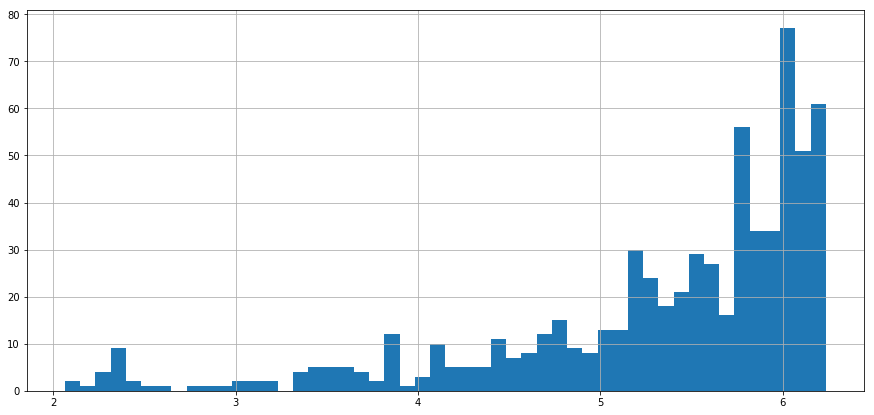

In [26]:
tfidf.tfidf.hist(bins=50, figsize=(15,7))

Let's display the 30 tokens that have the lowest tfidf scores 

In [28]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(30)

,tfidf
labeling,2.063454
may,2.133048
label,2.172869
mg,2.232420
labeling label,2.240746
exp,2.292216
tablet,2.293978
potentially,2.317173
mixup,2.342768
label mixup,2.342768


In [27]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(30)

,tfidf
containing,6.236442
product meet,6.236442
incorrectly labeled,6.236442
stability test,6.236442
subpotent single,6.236442
manufacture,6.236442
inc. recalling,6.236442
data support,6.236442
metal,6.236442
related compound,6.236442


We end up with less common words. These words naturally carry more meaning for the given description and may outline the underlying topic.

As you've noticed, the documents have more than 4000 features (see the vz shape). put differently, each document has more than 4000 dimensions.

If we want to plot them like we usually do with geometric objects, we need to reduce their dimension to 2 or 3 depending on whether we want to display on a 2D plane or on a 3D space. This is what we call dimensionality reduction.

To perform this task, we'll be using a combination of two popular techniques: Singular Value Decomposition (SVD) to reduce the dimension to 50 and then t-SNE to reduce the dimension from 50 to 2. t-SNE is more suitable for dimensionality reduction to 2 or 3.

Let's start reducing the dimension of each vector to 50 by SVD.

In [29]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vz)

In [30]:
svd_tfidf.shape

(2067, 50)

Bingo. Now let's do better. From 50 to 2!

In [31]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2067
[t-SNE] Computed conditional probabilities for sample 2000 / 2067
[t-SNE] Computed conditional probabilities for sample 2067 / 2067
[t-SNE] Mean sigma: 0.209879
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.926147
[t-SNE] Error after 275 iterations: 0.926147


Let's check the size.

In [32]:
tsne_tfidf.shape

(2067, 2)

Each description is now modeled by a two dimensional vector. 

Let's see what tsne_idf looks like.

In [33]:
tsne_tfidf

array([[  4.80597892, -15.30646165],
       [ -5.43228421,   5.17716947],
       [ -3.29478211,  -5.28430408],
       ..., 
       [-14.57378715,   4.72937416],
       [ -4.1213616 ,   3.65900702],
       [  0.40697127,  -9.73243275]])

We're having two float numbers per discription. This is not interpretable at first sight. 

What we need to do is find a way to display these points on a plot and also attribute the corresponding description to each point.

matplotlib is a very good python visualization libaray. However, we cannot easily use it to display our data since we need interactivity on the objects. One other solution could be d3.js that provides huge capabilities in this field. 

Right now I'm choosing to stick to python so I found a tradeoff : it's called Bokeh.

"Bokeh is a Python interactive visualization library that targets modern web browsers for presentation. Its goal is to provide elegant, concise construction of novel graphics in the style of D3.js, and to extend this capability with high-performance interactivity over very large or streaming datasets. Bokeh can help anyone who would like to quickly and easily create interactive plots, dashboards, and data applications." To know more, please refer to this <a href="http://bokeh.pydata.org/en/latest/"> link </a>

Let's start by importing bokeh packages and initializing the plot figure.

In [34]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

In [35]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [36]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['recalling_firm'] = data['recalling_firm']
tfidf_df['reason_for_recall'] = data['reason_for_recall']

Bokeh need a pandas dataframe to be passed as a source data. this is a very elegant way to read data.

In [37]:
plot_tfidf.scatter(x='x', y='y', source=tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"Recalling Firm": "@recalling_firm", "reason_for_recall":"@reason_for_recall"}
show(plot_tfidf)

Bokeh charts offer many functionalities:

- navigating in the data
- zooming
- hovering on each data point and displaying the corresponding description
- saving the chart

When the description popup doesn't show properly you have to move the data point slightly on the left.

By hovering on each news cluster, we can see groups of descriptions of similar keywords and thus referring to the same topic.

Now we're going to use clustering algorithms on the tf-idf matrix.

## Step 4: Clustering
[[ go back to the top ]](#Table-of-contents)

### KMeans
[[ go back to the top ]](#Table-of-contents)

Our starting point is the tf-idf matrix vz. Let's check its size again.

In [38]:
vz.shape

(2067, 669)

This matrix can be seen as a collection of (x) high-dimensional vectors (y). Some algorithms like K-means can crunch this data structure and produce blocks of similar or "close" data points based on some similarity measure like the euclidean distance.

One thing to know about Kmeans is that it needs the number of clusters up front. This number is usually found by trying different values until the result looks satisfactory.

I found that 20 was a good number that separates the dataset nicely.

In [39]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.cluster import MiniBatchKMeans

num_clusters = 20
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

Let's see the five first description and the associated cluster

In [40]:
for (i, desc),reason_for_recall in zip(enumerate(data.recalling_firm),data['reason_for_recall']):
    if(i < 5):
        print("Cluster " + str(kmeans_clusters[i]) + ": " + desc + 
              "(distance: " + str(kmeans_distances[i][kmeans_clusters[i]]) + ")")
        print('Reason For Recall: ',reason_for_recall)
        print('---')

Cluster 8: Mcneil Consumer Healthcare, Div Of Mcneil-ppc, Inc.(distance: 0.810709785989)
Reason For Recall:  Defective Container; damaged blister units 
---
Cluster 17: Hospira, Inc.(distance: 0.963003526509)
Reason For Recall:  Superpotent (Single Ingredient) Drug: Above specification assay results for percentage of magnesium sulfate.
---
Cluster 11: Physicians Total Care, Inc(distance: 0.990185904985)
Reason For Recall:  Labeling: Label mix-up; Bottles labeled to contain Morphine Sulfate IR may contain Morphine Sulfate ER and vice-versa.   
---
Cluster 6: Apotex Inc.(distance: 0.803015505726)
Reason For Recall:  Presence of Particulate Matter:  Lots identified in this recall notification may contain small particulates. 
---
Cluster 11: Dr. Reddy's Laboratories, Inc.(distance: 0.860013333167)
Reason For Recall:  Adulterated Presence of Foreign Tablets: Dr. Reddy's Laboratories has received complaints of mislabeled bottles of Amlodipine Besylate and Benazepril Hydrochloride Capsules an

This doesn't tell us much. What we need to look up are the "hot" keywords that describe each clusters. 

In [41]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        aux += terms[j] + ' | '
    print(aux)
    print() 

Cluster 0:
tablet/capsule | failed tablet/capsule | tablet/capsule specifications | specifications | failed | tablets | broken | broken tablets | tablet | capsules | 

Cluster 1:
incorrect | missing | labeling | date | label | labeling incorrect | lot | incorrect missing | product | and/or | 

Cluster 2:
ascorbic | ascorbic acid | mg | tablet mg | tablet | acid | acid tablet | mg ndc | ndc pedigree | pedigree | 

Cluster 3:
dissolution | failed dissolution | failed | dissolution specifications | specifications | specification | point | time point | time | month | 

Cluster 4:
active | ingredient | undeclared | active ingredient | product | active pharmaceutical | pharmaceutical | contain undeclared | approved | ingredients | 

Cluster 5:
non-sterility | uniformity | content | content uniformity | failed | failed content | uniformity specifications | due | mold | contamination | 

Cluster 6:
particulate | matter | particulate matter | presence particulate | presence | glass | identified

Looking at these clusters you can roughly have an idea of what's going on.


Let's plot these clusters. To do this we need to reduce the dimensionality of kmeans_distances to 2.

In [42]:
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2067
[t-SNE] Computed conditional probabilities for sample 2000 / 2067
[t-SNE] Computed conditional probabilities for sample 2067 / 2067
[t-SNE] Mean sigma: 0.048427
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.863045
[t-SNE] Error after 300 iterations: 0.863045


Let's use a color palette to assign different colors to each cluster 

In [43]:
import numpy as np

colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b"])

plot_kmeans = bp.figure(plot_width=700, plot_height=600, title="KMeans clustering of the Drug Recalls",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [44]:
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['recalling_firm'] = data['recalling_firm']
kmeans_df['reason_for_recall'] = data['reason_for_recall']

In [45]:
plot_kmeans.scatter(x='x', y='y', 
                    color=colormap[kmeans_clusters], 
                    source=kmeans_df)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"Recalling Firm": "@recalling_firm", "Reason For Recall": "@reason_for_recall", "cluster":"@cluster"}
show(plot_kmeans)

It looks like clusters are separated nicely. By hovering on each one of them you can see the corresponding descriptions. At first sight you could notice that they deal approximately with the same topic. This is coherent since we build our clusters using similarities between relevant keywords.

We can also notice that within the same cluster, many subclusters are isolated from one another. This gives an idea about the global topic as well as the 


Kmeans separates the documents into disjoint clusters. the assumption is that each cluster is attributed a single topic.

However, descriptions may in reality be characterized by a "mixture" of topics. We'll cover how to deal with this problem with the LDA algorithm.

### Latent Dirichlet Allocation
[[ go back to the top ]](#Table-of-contents)

Let's apply LDA on the data set. We'll set the number of topics to 20.

In [46]:
import lda
from sklearn.feature_extraction.text import CountVectorizer

In [47]:
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [48]:
cvectorizer = CountVectorizer(min_df=4, max_features=10000, tokenizer=tokenizer, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(data['reason_for_recall'])

n_topics = 20
n_iter = 2000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

In [49]:
n_top_words = 8
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: cgmp deviations cgmp deviations manufactured manufacturing recalled product uniformity
Topic 1: tablet mg exp pedigree ndc ndc pedigree mg ndc tablet mg
Topic 2: presence tablets foreign presence foreign mg substance foreign substance found
Topic 3: contamination products recalled microbial product microbial contamination due recalled due
Topic 4: drug subpotent subpotent drug ingredient assay active superpotent product
Topic 5: recalling lot lots may due recalled one one lot
Topic 6: mg ndc pedigree ndc pedigree exp mg ndc tablet capsule
Topic 7: tablet mg tablet mg exp pedigree ndc ndc pedigree mg ndc
Topic 8: recall initiated insert package package insert recall initiated due packaged
Topic 9: particulate matter particulate matter presence presence particulate glass identified vial
Topic 10: mcg sodium tablet mcg mcg ndc sodium tablet may chloride levothyroxine sodium
Topic 11: specifications failed tablet/capsule tablets failed tablet/capsule due tablet/capsule specificati

In [50]:
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2067
[t-SNE] Computed conditional probabilities for sample 2000 / 2067
[t-SNE] Computed conditional probabilities for sample 2067 / 2067
[t-SNE] Mean sigma: 0.052749
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.867688
[t-SNE] Error after 225 iterations: 0.867688


In [51]:
doc_topic = lda_model.doc_topic_
lda_keys = []
for i, tweet in enumerate(data['reason_for_recall']):
    lda_keys += [doc_topic[i].argmax()]

In [52]:
plot_lda = bp.figure(plot_width=700, plot_height=600, title="LDA topic visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [53]:
lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['recalling_firm'] = data['recalling_firm']
lda_df['reason_for_recall'] = data['reason_for_recall']

In [54]:
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

In [55]:
plot_lda.scatter(source=lda_df, x='x', y='y', color=colormap[lda_keys])

hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"Recalling Firm":"@recalling_firm", "topic":"@topic", "Reason For Recall":"@reason_for_recall"}
show(plot_lda)

### Visualization of the topics using pyLDAvis
[[ go back to the top ]](#Table-of-contents)

Now we're going to use a more convenient visualization to explore LDA topics. It's called pyldavis.

In [56]:
lda_df['len_docs'] = data['tokens'].map(len)

In [57]:
def prepareLDAData():
    data = {
        'vocab': vocab,
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

In [58]:
ldadata = prepareLDAData()

In [59]:
import pyLDAvis

In [60]:
pyLDAvis.enable_notebook()

In [61]:
prepared_data = pyLDAvis.prepare(**ldadata)

In [62]:
pyLDAvis.save_html(prepared_data,'./pyldadavis_drug_recalls.html')

## Step 5: Conclusion
[[ go back to the top ]](#Table-of-contents)
In this post we explored many topics. 

- We set up a script to automatically extract newsfeed data from a REST API called newsapi.
- We processed the raw text by using different tools (pandas, nltk, scikit-learn)
- We applied tf-idf statistics as a natural language preprocessing technique
- We created clusters on top of the tf-idf matrix using the KMeans algorithm and visualized them using Bokeh
- We extracted topics using the Latent Dirichlet Allocation algorithm and visualized them using Bokeh and pyldavis

Different techniques have been used but I'm pretty sure there's plenty of better methods. In fact, one way to extend this tutorial could be to dive in: 

- word2vec and doc2vec to model the topics
- setting up a robust way to select the number of clusters/topics up front

Thanks for reading ! Don't hesitate to comment if you have a suggestion or an improvement. 

## Step 6: References
[[ go back to the top ]](#Table-of-contents)

- https://newsapi.org/
- http://scikit-learn.org/stable/modules/feature_extraction.html
- https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- http://pythonhosted.org/lda/
- http://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb#topic=3&lambda=0.87&term=